In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/video-file-for-lane-detection-project/test_video.mp4
/kaggle/input/road-image-with-lanes/test_image.jpg


In [2]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display
%matplotlib inline

### We will first show the image in colour using OpenCV

<function matplotlib.pyplot.show(close=None, block=None)>

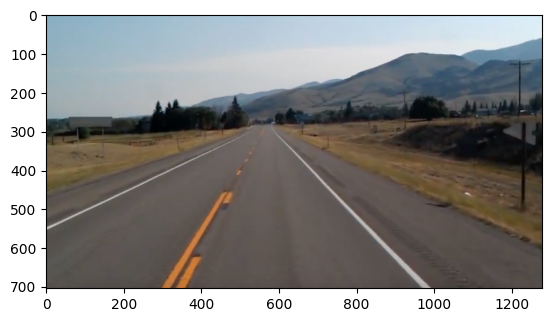

In [3]:
image = cv2.cvtColor(cv2.imread("../input/road-image-with-lanes/test_image.jpg"), cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show

In [4]:
import numpy as np

lane_image = np.copy(image)
lane_image.shape

(704, 1279, 3)

## **NOW we change it to GRAYSCALE Image**

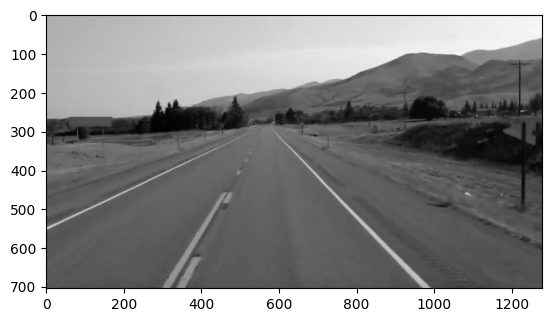

In [5]:
gray_img = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.show()

## **NOW we will apply a Gaussian Blur**

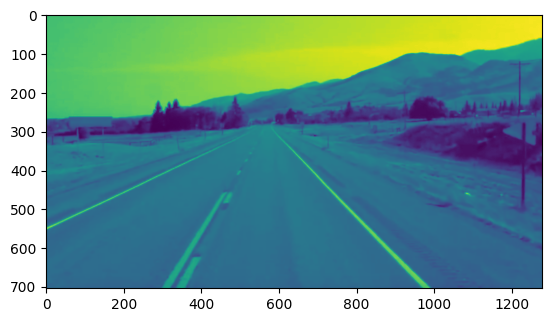

In [6]:
blurred_img = cv2.GaussianBlur(gray_img, (5,5), 0)

plt.imshow(blurred_img)
plt.show()

## **NOW we will apply Canny to show the edges**

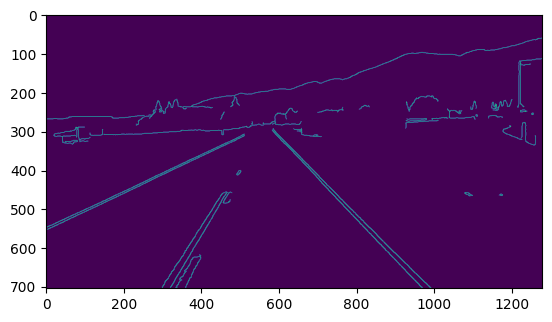

In [7]:
canny_img = cv2.Canny(blurred_img, 50, 150)

plt.imshow(canny_img)
plt.show()

## **INSTEAD** of applying all these filters one by one, lets group them together**
## We will make a function, and put all of the filters in it so at the end all we need to do is specify the function for it to work

In [8]:
def Canny(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
   # plt.imshow(gray_img, cmap='gray')
    #plt.show()
    blur_img = cv2.GaussianBlur(gray_img, (5,5), 0)
    #plt.imshow(blur_img)
    #plt.show()
    canny_img = cv2.Canny(blur_img, 50, 150)
    #plt.imshow(canny_img)
   # plt.show()

    return canny_img


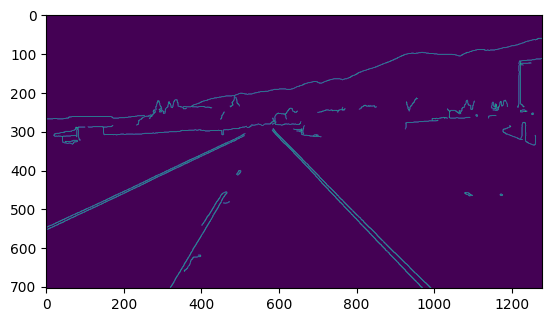

In [9]:
image = cv2.imread('/kaggle/input/road-image-with-lanes/test_image.jpg')
lane_image = np.copy(image)
canny = Canny(lane_image)

plt.imshow(canny)

In [10]:
def region_of_interest(image):
    height = 700
    polygons = np.array([[(250,height), (1000,height), (600,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_region = cv2.bitwise_and(image, mask)
    
    return masked_region

In [11]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            if line is not None and len(line) == 4:
                x1, y1, x2, y2 = line
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

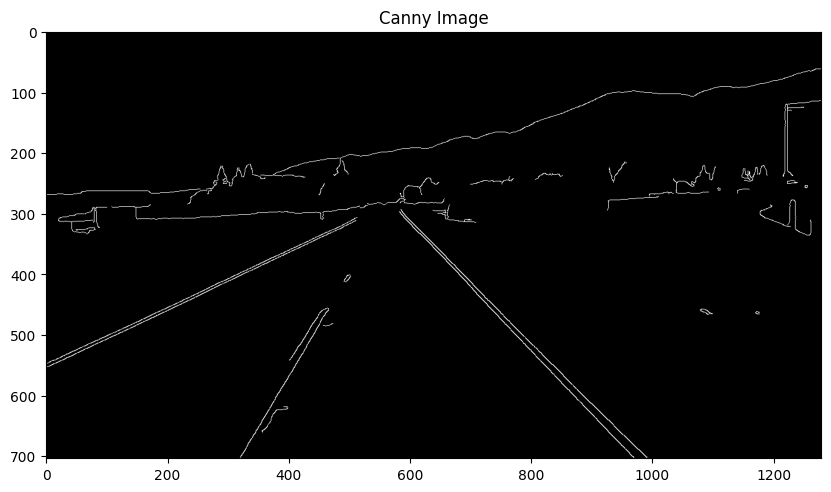

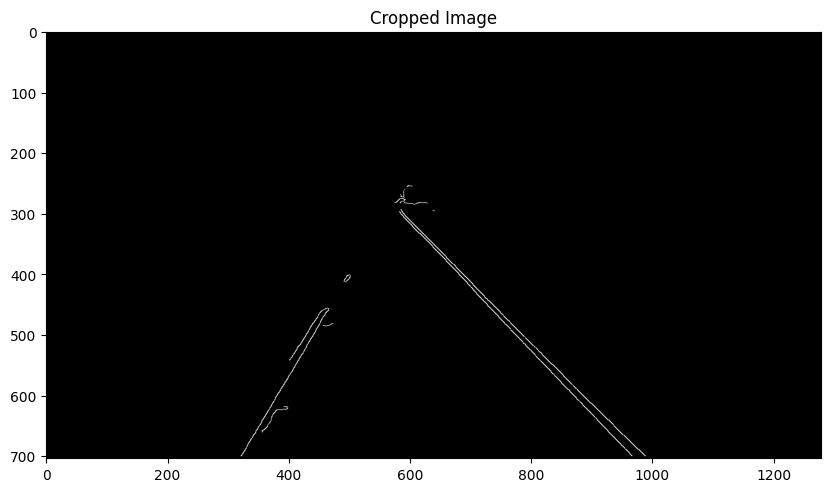

Lines: [[[750 465 834 549]]

 [[787 514 967 700]]

 [[900 613 976 689]]

 [[331 684 452 481]]

 [[617 333 695 414]]

 [[619 330 731 445]]

 [[710 433 850 578]]

 [[806 519 879 594]]

 [[402 542 455 460]]

 [[592 304 646 358]]

 [[732 446 822 536]]]


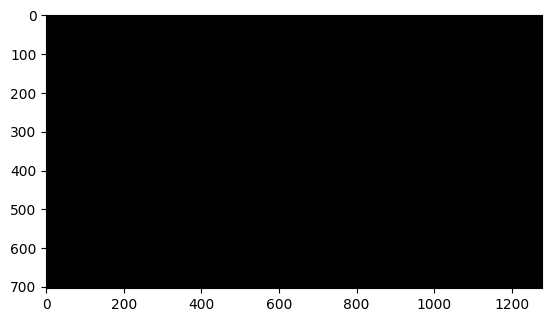

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('/kaggle/input/road-image-with-lanes/test_image.jpg')
lane_image = np.copy(image)
canny_image = Canny(lane_image)

# Display the canny_image
plt.figure(figsize=(10, 6))
plt.imshow(canny_image, cmap='gray')
plt.title('Canny Image')
plt.show()

cropped_image = region_of_interest(canny_image)

# Display the cropped_image
plt.figure(figsize=(10, 6))
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.show()

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
print('Lines:', lines)  # Print the detected lines

line_image = display_lines(lane_image, lines)
plt.imshow(line_image)
plt.show()

## **NOW** we will combine both of these images to make the lines be shown on road image

<function matplotlib.pyplot.show(close=None, block=None)>

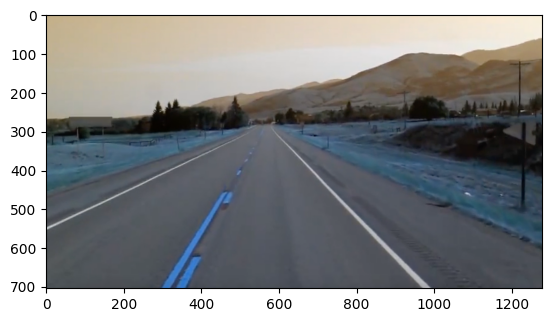

In [13]:
combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show

## **NOW** we will do some optimization on the lines to make sure they are straight and look good

In [14]:
def make_coordinates(image, line_parameters):
    if isinstance(line_parameters, (list, tuple, np.ndarray)):
        slope, intercept = line_parameters
    else:
        # Handle the case when line_parameters is not an iterable
        # e.g., return default line coordinates or skip this line
        return None, None

    y1 = image.shape[0]
    y2 = int(y1 * (3 / 5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [15]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    left_line = None
    right_line = None

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            if slope < 0:
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))

    if left_fit:
        left_fit_average = np.average(left_fit, axis=0)
        left_line = make_coordinates(image, left_fit_average)

    if right_fit:
        right_fit_average = np.average(right_fit, axis=0)
        right_line = make_coordinates(image, right_fit_average)

    return left_line, right_line

## **REPEAT** all the steps again

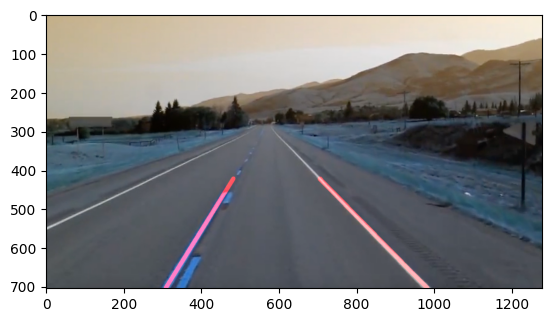

In [16]:
# first we get the image
image = cv2.imread('/kaggle/input/road-image-with-lanes/test_image.jpg')

# then we get the numpy array
lane_image = np.copy(image)

# now applying all filters
canny_image = Canny(lane_image)

# time to crop the image
cropped_image = region_of_interest(canny_image)

# Put HoughLines and get the lines out of the image
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)

# Now combine the lines with the image of the road
combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)


plt.imshow(combo_image)
plt.show()

## **NOW** we will take the video, take apart all the frames and let the model recognise the lanes in each frame.

In [17]:
import cv2
import numpy as np
from IPython.display import Video

# Assuming the Canny, region_of_interest, average_slope_intercept and display_lines functions are defined

cap = cv2.VideoCapture("/kaggle/input/video-file-for-lane-detection-project/test_video.mp4")

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 30, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        canny_image = Canny(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
        averaged_lines = average_slope_intercept(frame, lines)
        left_line, right_line = averaged_lines
        if left_line is not None and right_line is not None:
            lines = np.array([left_line, right_line])
            line_image = display_lines(frame, lines)
        else:
            line_image = np.zeros_like(frame)
        combo_image = cv2.addWeighted(frame, 1, line_image, 1, 1)
        out.write(combo_image)  # Write the processed frame to the output video
    else:
        break

cap.release()
out.release()

# Display the processed video
Video("output.mp4")

## 